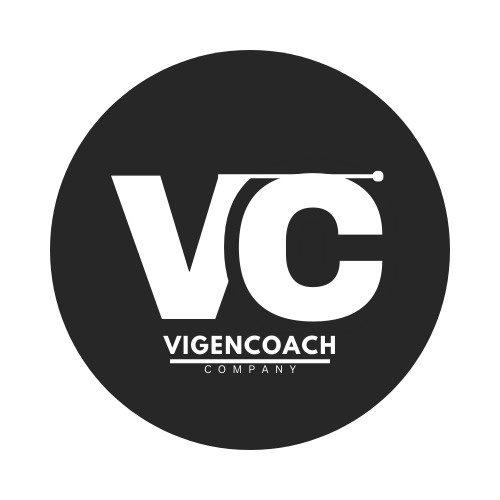



Let's build a Football AI system to dig deeper into match stats! We'll use computer vision and machine learning to track players, determine which team is which, and even calculate stuff like ball possession and speed. This tutorial is perfect if you want to get hands-on with sports analytics and see how AI can take your football analysis to the next level.


## Before you start

### Configure your API keys

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed Mar 26 01:44:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   51C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install numpy==1.23.5


## Install dependencjes

**Note:** Let's install the `inference-gpu` library, which will be used to efficiently run our object detection and keypoint detection models on GPUs. `inference-gpu` utilizes the `onnxruntime-gpu` library internally for optimal performance. We'll install a specific version of `onnxruntime-gpu` to guarantee compatibility with the CUDA 12 environment in Google Colab.

In [ ]:
!pip install -q gdown inference-gpu
!pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Note:** Let's install the sports repository directly from GitHub. The sports repository contains a variety of football-related utilities that we'll use along the way.

In [ ]:
!pip install -q git+https://github.com/roboflow/sports.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 12.4 MB/s eta 0:00:00


**Note:** Let's make sure we have the latest features in the supervision library by installing version `0.23.0` or higher.

In [ ]:
!pip uninstall -y supervision && pip install -q supervision>=0.23.0

Found existing installation: supervision 0.25.1
Uninstalling supervision-0.25.1:
  Successfully uninstalled supervision-0.25.1


**Note:** Let's download a few sample videos from the [DFL - Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout) Kaggle competition using gdown.



In [ ]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /content/0bfacc_0.mp4
100% 19.9M/19.9M [00:00<00:00, 45.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: /content/2e57b9_0.mp4
100% 21.1M/21.1M [00:00<00:00, 91.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
To: /content/08fd33_0.mp4
100% 19.9M/19.9M [00:01<00:00, 17.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
To: /content/573e61_0.mp4
100% 18.9M/18.9M [00:00<00:00, 23.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /content/121364_0.mp4
100% 17.2M/17.2M [00:00<00:00, 96.3MB/s]


In [ ]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [ ]:
!pip install 'inference[transformers]'
!pip install 'inference[sam]'
!pip install 'inference[clip]'
!pip install 'inference[gaze]'
!pip install 'inference[grounding-dino]'
!pip install 'inference[yolo-world]'


  Using cached rf_segment_anything-1.0-py3-none-any.whl.metadata (583 bytes)
  Using cached samv2-0.0.4-py3-none-any.whl.metadata (3.2 kB)
  Using cached rasterio-1.4.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached iopath-0.1.10.tar.gz (42 kB)
  Preparing metadata (setup.py) ... done
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached antlr4-python3-runtime-4.9.3.tar.gz (117 kB)
  Preparing metadata (setup.py) ... done
  Using cached portalocker-3.1.1-py3-none-any.whl.metadata (8.6 kB)
Using cached rf_segment_anything-1.0-py3-none-any.whl (36 kB)
Us

  Using cached rf_clip-1.1-py3-none-any.whl.metadata (280 bytes)
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
^C
^C
^C


## ball, player, goalkeeper and referee detection

In [ ]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/11"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support GroundingDINO model. Use pip install 'inference[grounding-dino]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support YoloWorld model. Use pip install 'inference[yolo-world]' to install missing requirements.


In [ ]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/11"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

# Print model information (workaround)
# Since `get_info` doesn't exist, let's print the model itself
# to get some information about it.
print(PLAYER_DETECTION_MODEL)

# OR, Access model properties directly (if available)
# For instance, if the model has 'model_type', 'model_path' etc. as properties,
# you can access them directly
# print(f"Model Type: {PLAYER_DETECTION_MODEL.model_type}")
# print(f"Model Path: {PLAYER_DETECTION_MODEL.model_path}")

# Depending on the library/class structure, you might need to explore
# its available methods/properties to get the desired information.

In [ ]:
#!pip install opencv-python-headless==4.8.0.76

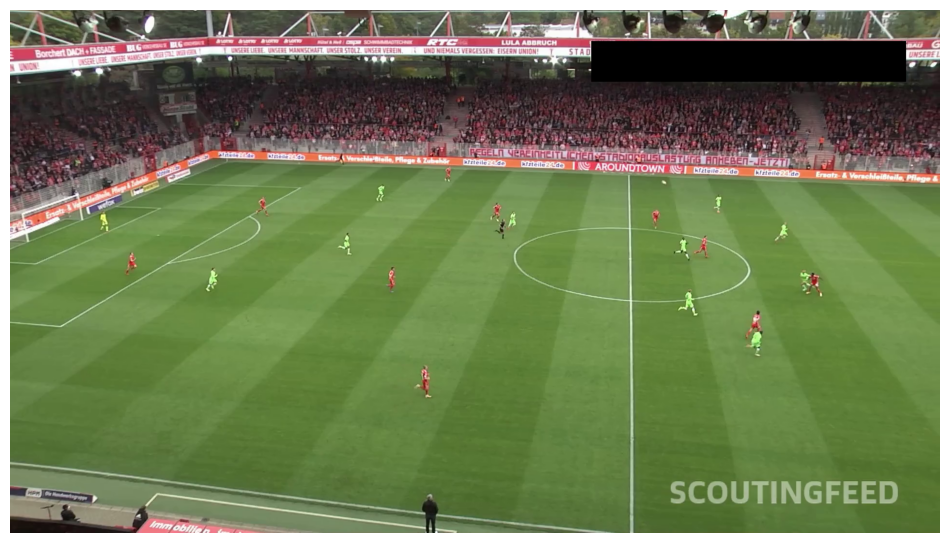

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

In [ ]:
'''import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)'''

In [ ]:
#to process all frames

from tqdm import tqdm
import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
TARGET_VIDEO_PATH = "/content/121364_0_result_1.mp4"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#008FFF', '#FF1493', '#FFD700']),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#008FFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        labels = [
            f"{class_name} {confidence:.2f}"
            for class_name, confidence in zip(detections['class_name'], detections.confidence)
        ]

        annotated_frame = frame.copy()
        annotated_frame = box_annotator.annotate(annotated_frame, detections)
        annotated_frame = label_annotator.annotate(annotated_frame, detections, labels=labels)

        video_sink.write_frame(annotated_frame)

## video game style visualization

In [ ]:
'''import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)'''

## player tracking

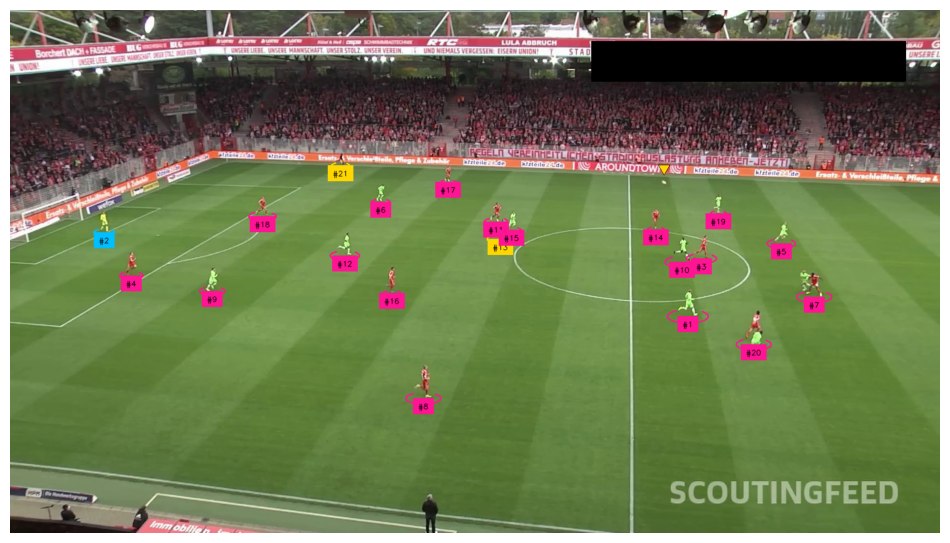

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

## split players into teams

![football AI diagram](https://media.roboflow.com/notebooks/examples/football-ai-team-clustering.png)

**Note:** Before training our player clustering model, we need to gather training data. To do this, we'll sample one frame per second, detect players within those frames, and then crop them out.

In [ ]:
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

collecting crops: 25it [01:06,  2.68s/it]


In [ ]:
len(crops)

478

**Note:** Here's a sample (100 elements) of the crops we've gathered.

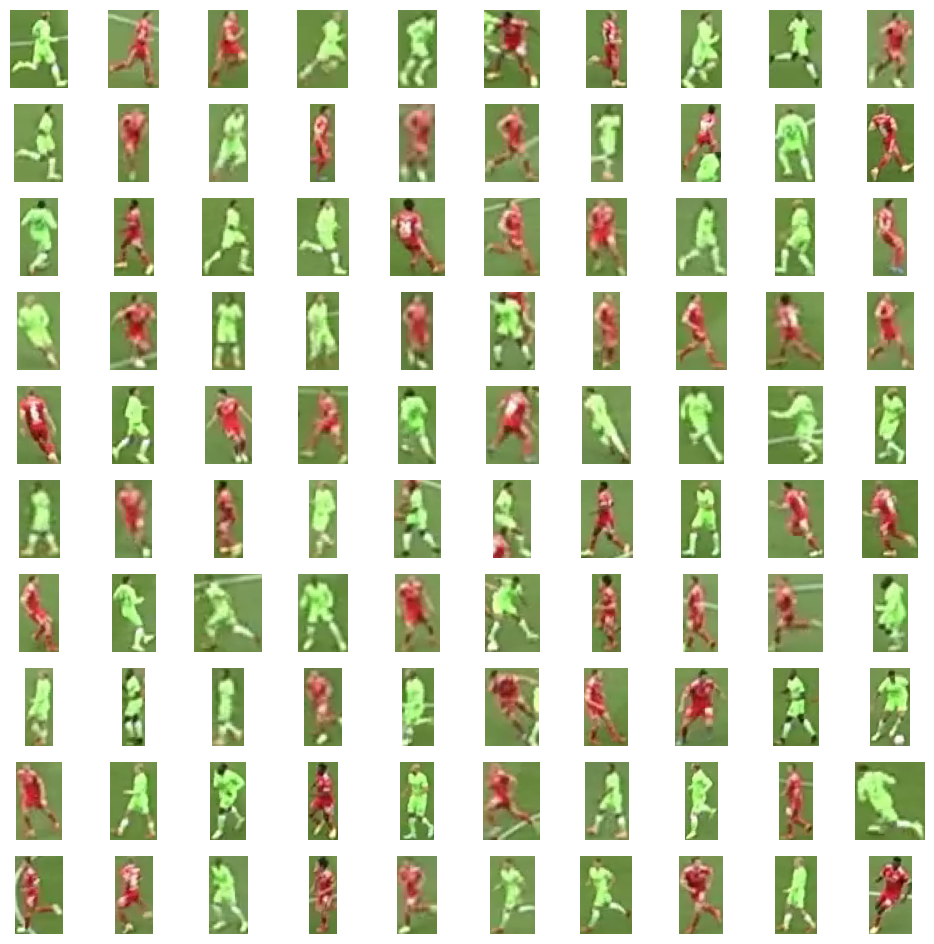

In [ ]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

**Note:** Next, we'll run [SigLIP](https://huggingface.co/docs/transformers/en/model_doc/siglip) to calculate embeddings for each of the crops.

In [ ]:
# now we need to build another algorithm to automatically sort them into those two teams so I prepared a code sigLIP, that will allow us to load sigLIP model that we'll use to create embeddings for those crops

import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [ ]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 15it [00:03,  4.23it/s]


**Note:** Using [UMAP](https://github.com/lmcinnes/umap), we project our embeddings from `(N, 768)` to `(N, 3)` and then perform a two-cluster division using [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [ ]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [ ]:
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [ ]:
clusters[:10]

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0], dtype=int32)

In [ ]:
team_0 = [
    crop
    for crop, cluster in zip(crops, clusters)
    if cluster == 0
]


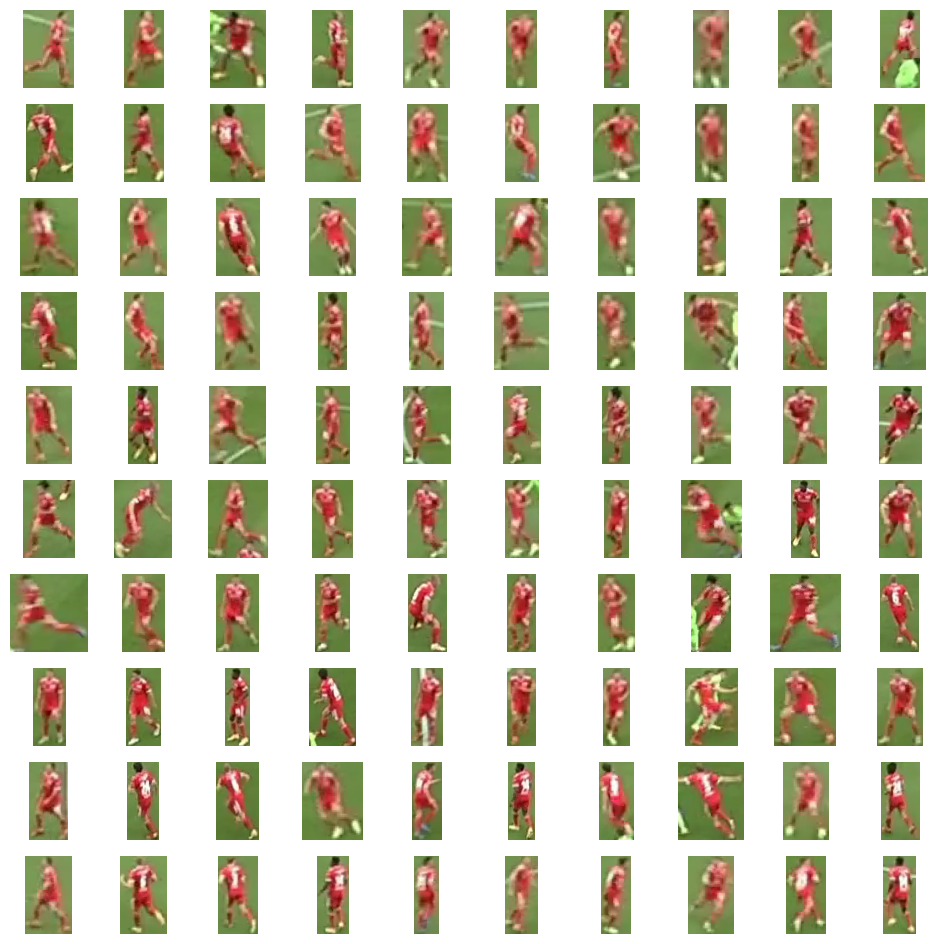

In [ ]:
sv.plot_images_grid(team_0[:100], grid_size=(10, 10))

In [ ]:
team_1 = [
    crop
    for crop, cluster in zip(crops, clusters)
    if cluster == 1
]

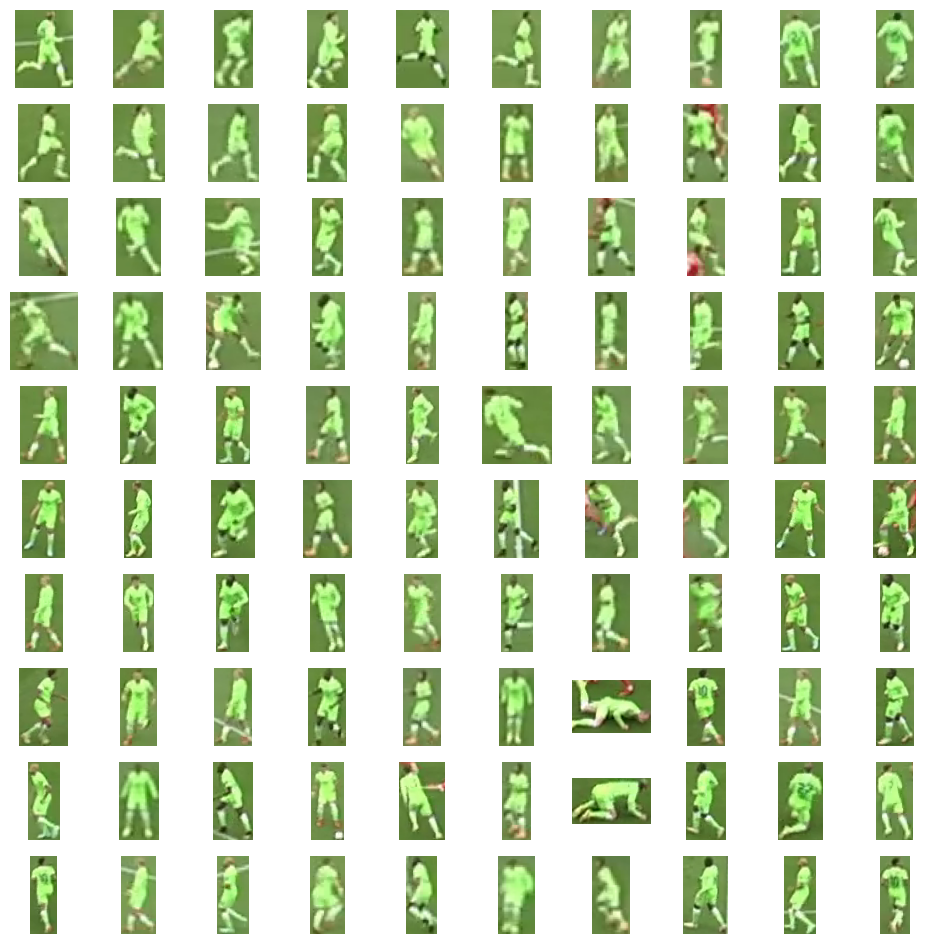

In [ ]:
sv.plot_images_grid(team_1[:100], grid_size=(10, 10))

**Note:** Here's an interactive visualization of our results. Click on a dot to display its associated crop.


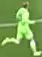
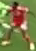
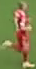
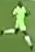
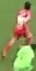
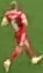
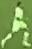
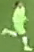
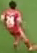
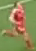
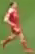
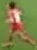
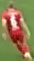
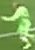
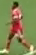
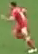
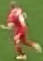
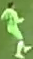
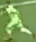
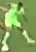
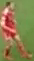
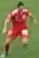
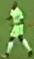
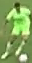
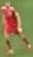
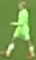
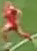
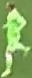
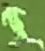
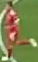
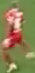
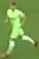
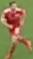
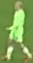
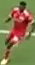
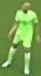
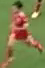
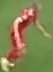
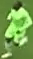
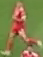
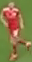
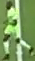
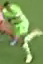
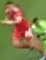
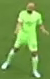
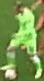
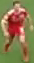
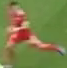
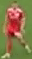
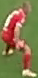
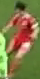
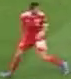
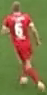
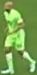
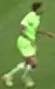
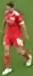
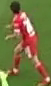
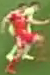
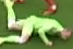
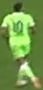
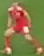
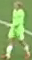
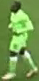
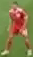
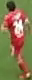
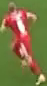
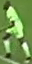
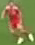
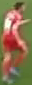
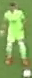
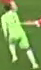
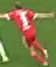
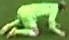
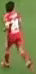
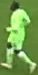
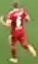
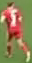
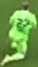
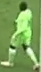
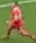
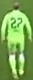
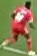
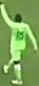
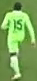
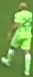
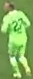
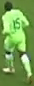
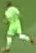
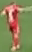
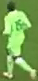
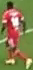
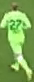
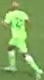
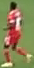
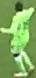
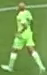
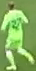
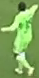
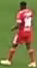
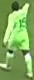
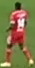
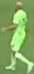
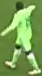
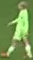
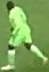
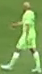
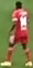
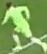
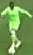
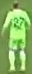
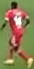
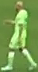
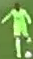
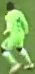
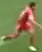
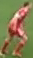
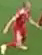
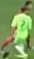
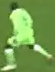
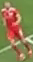
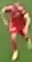
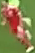
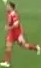
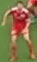
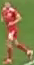
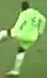
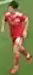
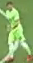
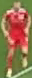

In [ ]:
import plotly.graph_objects as go
import numpy as np
from typing import Dict, List
from IPython.core.display import display, HTML
from PIL import Image
import base64
from io import BytesIO


def pil_image_to_data_uri(image: Image.Image) -> str:
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"


def display_projections(
    labels: np.ndarray,
    projections: np.ndarray,
    images: List[Image.Image],
    show_legend: bool = False,
    show_markers_with_text: bool = True
) -> None:
    image_data_uris = {f"image_{i}": pil_image_to_data_uri(image) for i, image in enumerate(images)}
    image_ids = np.array([f"image_{i}" for i in range(len(images))])

    unique_labels = np.unique(labels)
    traces = []
    for unique_label in unique_labels:
        mask = labels == unique_label
        customdata_masked = image_ids[mask]
        trace = go.Scatter3d(
            x=projections[mask][:, 0],
            y=projections[mask][:, 1],
            z=projections[mask][:, 2],
            mode='markers+text' if show_markers_with_text else 'markers',
            text=labels[mask],
            customdata=customdata_masked,
            name=str(unique_label),
            marker=dict(size=8),
            hovertemplate="<b>class: %{text}</b><br>image ID: %{customdata}<extra></extra>"
        )
        traces.append(trace)

    fig = go.Figure(data=traces)
    fig.update_layout(
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        width=1000,
        height=1000,
        showlegend=show_legend
    )

    plotly_div = fig.to_html(full_html=False, include_plotlyjs=False, div_id="scatter-plot-3d")

    javascript_code = f"""
    <script>
        function displayImage(imageId) {{
            var imageElement = document.getElementById('image-display');
            var placeholderText = document.getElementById('placeholder-text');
            var imageDataURIs = {image_data_uris};
            imageElement.src = imageDataURIs[imageId];
            imageElement.style.display = 'block';
            placeholderText.style.display = 'none';
        }}

        var chartElement = document.getElementById('scatter-plot-3d');

        chartElement.on('plotly_click', function(data) {{
            var customdata = data.points[0].customdata;
            displayImage(customdata);
        }});
    </script>
    """

    html_template = f"""
    <!DOCTYPE html>
    <html>
        <head>
            <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            <style>
                #image-container {{
                    position: fixed;
                    top: 0;
                    left: 0;
                    width: 200px;
                    height: 200px;
                    padding: 5px;
                    border: 1px solid #ccc;
                    background-color: white;
                    z-index: 1000;
                    box-sizing: border-box;
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    text-align: center;
                }}
                #image-display {{
                    width: 100%;
                    height: 100%;
                    object-fit: contain;
                }}
            </style>
        </head>
        <body>
            {plotly_div}
            <div id="image-container">
                <img id="image-display" src="" alt="Selected image" style="display: none;" />
                <p id="placeholder-text">Click on a data entry to display an image</p>
            </div>
            {javascript_code}
        </body>
    </html>
    """

    display(HTML(html_template))

display_projections(clusters, projections, crops)

**Note:** To simplify the use of the SigLIP, UMAP, and KMeans combo, I've packaged all these models into a [`TeamClassifier`](https://github.com/roboflow/sports/blob/06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1/sports/common/team.py#L41) that you can find in the [sports](https://github.com/roboflow/sports) repository.

In [ ]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [01:10,  2.80s/it]
Embedding extraction: 18it [00:03,  4.70it/s]


**Note:** Time to assign goalkeepers to teams. We'll use a simple heuristic: calculate the average position (centroid) of the players belonging to both teams and then assign the goalkeeper to the team whose average position is closer.

In [ ]:
import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

 Image(single frame):

Embedding extraction: 1it [00:00,  8.03it/s]


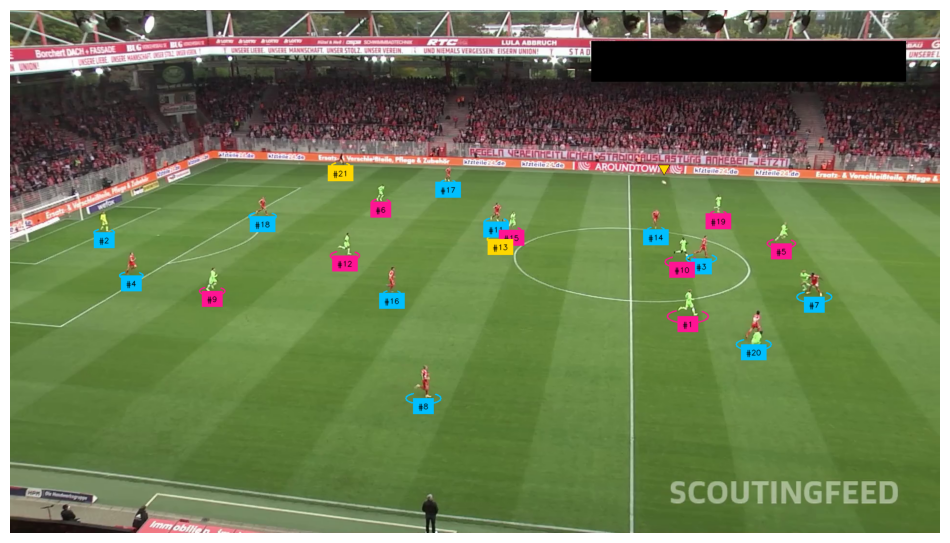

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

Processes the entire video:

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
TARGET_VIDEO_PATH = "/content/121364_0_anntated.mp4"

# Define class IDs
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

# Initialize annotators
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

# Initialize tracker
tracker = sv.ByteTrack()
tracker.reset()

# Get video information and initialize writer
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)


# Process the video frame by frame
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        # Perform object detection
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        # Process ball detections
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        # Process other detections (excluding ball)
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)

        # Split detections by category
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        # Classify players
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        # Resolve goalkeeper team ID
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

        # Adjust referee class IDs
        referees_detections.class_id -= 1

        # Merge detections
        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections
        ])

        # Generate labels
        labels = [
            f"#{tracker_id}"
            for tracker_id in all_detections.tracker_id
        ]
        all_detections.class_id = all_detections.class_id.astype(int)

        # Annotate the frame
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections)
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections,
            labels=labels)
        annotated_frame = triangle_annotator.annotate(
            scene=annotated_frame,
            detections=ball_detections)

        # Write the frame to the output video
        video_sink.write_frame(annotated_frame)

print(f"Annotated video saved to: {TARGET_VIDEO_PATH}")


# Let's try to add the speed:



In [ ]:
import math
import supervision as sv
from tqdm import tqdm
from collections import deque
from typing import Dict, Any, Tuple

# Define file paths
SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
TARGET_VIDEO_PATH = "/content/121364_0_withSpeed.mp4"

# Define class IDs
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

# Speed Estimator Class
class SpeedEstimator:
    """Estimates the speed of objects (km/h)."""
    def __init__(self, field_width: int = 528, field_height: int = 352,
                 real_field_length: float = 100, real_field_width: float = 50,
                 smoothing_window: int = 5) -> None:
        self.field_width = field_width
        self.field_height = field_height
        self.real_field_length = real_field_length
        self.real_field_width = real_field_width
        self.previous_positions: Dict[Any, Tuple[Tuple[float, float], int]] = {}
        self.speed_history: Dict[Any, deque] = {}
        self.smoothing_window = smoothing_window
        self.scale_x = real_field_length / field_width
        self.scale_y = real_field_width / field_height
        self.max_speed = 40.0  # km/h

    def calculate_speed(self, detections, frame_number: int, fps: float) -> Dict[int, float]:
        speeds = {}
        for i, xyxy in enumerate(detections.xyxy):
            tracker_id = detections.tracker_id[i]
            x, y = (xyxy[0] + xyxy[2]) / 2, (xyxy[1] + xyxy[3]) / 2  # Center of bounding box

            if tracker_id in self.previous_positions:
                prev_position, prev_frame = self.previous_positions[tracker_id]
                distance = self._calculate_distance(prev_position, (x, y))
                time_diff = (frame_number - prev_frame) / fps
                speed = (distance / time_diff) * 3.6 if time_diff > 0 else 0.0
                speed = min(speed, self.max_speed)  # Apply max speed limit
                speed = self._smooth_speed(tracker_id, speed)
            else:
                speed = 0.0  # Default speed for first frame
                self.speed_history[tracker_id] = deque([0.0] * self.smoothing_window, maxlen=self.smoothing_window)

            self.previous_positions[tracker_id] = ((x, y), frame_number)
            speeds[tracker_id] = speed

        return speeds

    def _calculate_distance(self, pos1: Tuple[float, float], pos2: Tuple[float, float]) -> float:
        dx = (pos2[0] - pos1[0]) * self.scale_x
        dy = (pos2[1] - pos1[1]) * self.scale_y
        return math.sqrt(dx**2 + dy**2)

    def _smooth_speed(self, player_id: Any, speed: float) -> float:
        if player_id not in self.speed_history:
            self.speed_history[player_id] = deque([0.0] * self.smoothing_window, maxlen=self.smoothing_window)
        self.speed_history[player_id].append(speed)
        return sum(self.speed_history[player_id]) / len(self.speed_history[player_id])

# Initialize components
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

# Initialize tracker and speed estimator
tracker = sv.ByteTrack()
tracker.reset()
speed_estimator = SpeedEstimator()

# Get video information and initialize writer
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

# Process video frame by frame
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame_number, frame in tqdm(enumerate(frame_generator), total=video_info.total_frames):
        fps = video_info.fps  # Frames per second

        # Perform object detection
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        # Process ball detections
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        # Process other detections (excluding ball)
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)

        # Split detections by category
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        # Classify players
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        # Resolve goalkeeper team ID
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

        # Adjust referee class IDs
        referees_detections.class_id -= 1

        # Merge detections
        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections
        ])

        # Estimate player speeds
        speeds = speed_estimator.calculate_speed(all_detections, frame_number, fps)

        # Generate labels with speed info
        labels = [
            f"#{tracker_id} | {speeds[tracker_id]:.1f} km/h"
            for tracker_id in all_detections.tracker_id
        ]
        all_detections.class_id = all_detections.class_id.astype(int)

        # Annotate the frame
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections)
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections,
            labels=labels)
        annotated_frame = triangle_annotator.annotate(
            scene=annotated_frame,
            detections=ball_detections)

        # Write the frame to the output video
        video_sink.write_frame(annotated_frame)

print(f"Annotated video saved to: {TARGET_VIDEO_PATH}")


In [ ]:
#testing: done
#the speed work correctly

# Now we will add possession

In [ ]:
import math
import cv2
import supervision as sv
from tqdm import tqdm
from collections import deque
from typing import Dict, Any, Tuple

# -------------------------------
# USER-DEFINED CONSTANTS / CONFIG
# -------------------------------
SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
TARGET_VIDEO_PATH = "/content/121364_0_withSpeed_andPossession.mp4"

# Object class IDs from your detection model
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

# After classification:
#  - Team 1 will be labeled as 0
#  - Team 2 will be labeled as 1
TEAM_1_ID = 0
TEAM_2_ID = 1

# Global counters for ball possession
TEAM_1_POSSESSION_FRAMES = 0
TEAM_2_POSSESSION_FRAMES = 0


# ---------------------------
# HELPER FUNCTIONS FOR LABELS
# ---------------------------
def draw_ball_possession_info(frame, team1_count, team2_count):
    """
    Draws a semi-transparent box in the top-left corner of the frame,
    displaying the ball possession percentage for each team.
    """
    total = team1_count + team2_count
    if total == 0:
        # Avoid division by zero at the start
        team1_pct = 0.0
        team2_pct = 0.0
    else:
        team1_pct = (team1_count / total) * 100.0
        team2_pct = (team2_count / total) * 100.0

    # Coordinates for the info box
    x1, y1 = 50, 50
    x2, y2 = 450, 150

    # Draw semi-transparent rectangle
    overlay = frame.copy()
    cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 255, 255), -1)
    alpha = 0.4
    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

    # Write text
    cv2.putText(
        frame,
        f"Team 1 Ball Control: {team1_pct:.2f}%",
        (x1 + 10, y1 + 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 0, 0),
        2
    )
    cv2.putText(
        frame,
        f"Team 2 Ball Control: {team2_pct:.2f}%",
        (x1 + 10, y1 + 85),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 0, 0),
        2
    )
    return frame


def get_center(xyxy):
    """Return (cx, cy) center of bounding box [x1, y1, x2, y2]."""
    x1, y1, x2, y2 = xyxy
    return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)


def find_player_with_ball(ball_detections, all_detections, distance_threshold=50.0):
    """
    Returns (tracker_id, team_id) for the player controlling the ball.
    If no player is within 'distance_threshold' pixels of the ball center,
    returns (None, None).
    """
    if len(ball_detections) == 0:
        return None, None  # No ball detected in this frame

    # For simplicity, take the first ball detection
    ball_xyxy = ball_detections.xyxy[0]
    ball_center = get_center(ball_xyxy)

    closest_distance = float('inf')
    closest_player_idx = None

    for i, xyxy in enumerate(all_detections.xyxy):
        # Only check if detection is Team 1 or Team 2 (already classified)
        c_id = all_detections.class_id[i]
        if c_id in [TEAM_1_ID, TEAM_2_ID]:
            player_center = get_center(xyxy)
            dist = math.dist(ball_center, player_center)
            if dist < closest_distance:
                closest_distance = dist
                closest_player_idx = i

    # If no player was found or if the ball is too far, no possession
    if closest_player_idx is None or closest_distance > distance_threshold:
        return None, None

    # Return the tracker's ID and the team ID
    return (all_detections.tracker_id[closest_player_idx],
            all_detections.class_id[closest_player_idx])


# -----------------------
# SPEED ESTIMATOR CLASS
# -----------------------
class SpeedEstimator:
    """Estimates the speed of objects (km/h)."""
    def __init__(self, field_width: int = 528, field_height: int = 352,
                 real_field_length: float = 100, real_field_width: float = 50,
                 smoothing_window: int = 5) -> None:
        self.field_width = field_width
        self.field_height = field_height
        self.real_field_length = real_field_length
        self.real_field_width = real_field_width
        self.previous_positions: Dict[Any, Tuple[Tuple[float, float], int]] = {}
        self.speed_history: Dict[Any, deque] = {}
        self.smoothing_window = smoothing_window
        self.scale_x = real_field_length / field_width
        self.scale_y = real_field_width / field_height
        self.max_speed = 40.0  # km/h

    def calculate_speed(self, detections, frame_number: int, fps: float) -> Dict[int, float]:
        speeds = {}
        for i, xyxy in enumerate(detections.xyxy):
            tracker_id = detections.tracker_id[i]
            x, y = (xyxy[0] + xyxy[2]) / 2, (xyxy[1] + xyxy[3]) / 2  # Center of bounding box

            if tracker_id in self.previous_positions:
                prev_position, prev_frame = self.previous_positions[tracker_id]
                distance = self._calculate_distance(prev_position, (x, y))
                time_diff = (frame_number - prev_frame) / fps
                speed = (distance / time_diff) * 3.6 if time_diff > 0 else 0.0
                speed = min(speed, self.max_speed)  # Apply max speed limit
                speed = self._smooth_speed(tracker_id, speed)
            else:
                speed = 0.0  # Default speed for first frame
                self.speed_history[tracker_id] = deque([0.0] * self.smoothing_window, maxlen=self.smoothing_window)

            self.previous_positions[tracker_id] = ((x, y), frame_number)
            speeds[tracker_id] = speed

        return speeds

    def _calculate_distance(self, pos1: Tuple[float, float], pos2: Tuple[float, float]) -> float:
        dx = (pos2[0] - pos1[0]) * self.scale_x
        dy = (pos2[1] - pos1[1]) * self.scale_y
        return math.sqrt(dx**2 + dy**2)

    def _smooth_speed(self, player_id: Any, speed: float) -> float:
        if player_id not in self.speed_history:
            self.speed_history[player_id] = deque([0.0] * self.smoothing_window, maxlen=self.smoothing_window)
        self.speed_history[player_id].append(speed)
        return sum(self.speed_history[player_id]) / len(self.speed_history[player_id])


# -----------------------------------
# ANNOTATORS (ELLIPSE, LABEL, TRIANGLE)
# -----------------------------------
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

# ------------------------------------------
# INITIALIZE TRACKER, SPEED ESTIMATOR, VIDEO
# ------------------------------------------
tracker = sv.ByteTrack()
tracker.reset()
speed_estimator = SpeedEstimator()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

# ----------------------------------
# FRAME-BY-FRAME PROCESSING LOOP
# ----------------------------------
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# NOTE: You must define or load your detection model, e.g.:
# PLAYER_DETECTION_MODEL = ...
# and your team_classifier, e.g.:
# team_classifier = ...
# plus the function that resolves goalkeeper IDs:
# resolve_goalkeepers_team_id = ...

# Global counters for possession (accessible inside the loop)
global TEAM_1_POSSESSION_FRAMES
global TEAM_2_POSSESSION_FRAMES

with video_sink:
    for frame_number, frame in tqdm(enumerate(frame_generator), total=video_info.total_frames):
        fps = video_info.fps  # frames per second

        # 1) Perform object detection
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        # 2) Process ball detections
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        # 3) Process other detections (exclude ball)
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)

        # 4) Split out categories
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        # 5) Classify players (team_classifier => 0 or 1)
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        # 6) Resolve goalkeeper team ID (so that they become 0 or 1 as well)
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

        # 7) Adjust referee class IDs if your logic requires it
        #    In your example, you had: referees_detections.class_id -= 1
        #    So a referee (3) becomes 2
        referees_detections.class_id -= 1

        # 8) Merge them back
        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections
        ])

        # 9) Estimate speeds
        speeds = speed_estimator.calculate_speed(all_detections, frame_number, fps)

        # 10) Create labels for speed
        labels = [
            f"#{tracker_id} | {speeds[tracker_id]:.1f} km/h"
            for tracker_id in all_detections.tracker_id
        ]
        all_detections.class_id = all_detections.class_id.astype(int)

        # 11) Identify ball possession
        owner_tracker_id, owner_team_id = find_player_with_ball(ball_detections, all_detections)
        if owner_team_id == TEAM_1_ID:
            TEAM_1_POSSESSION_FRAMES += 1
        elif owner_team_id == TEAM_2_ID:
            TEAM_2_POSSESSION_FRAMES += 1

        # 12) Annotate the frame
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections,
            labels=labels
        )
        annotated_frame = triangle_annotator.annotate(
            scene=annotated_frame,
            detections=ball_detections
        )

        # 13) Draw ball possession info
        annotated_frame = draw_ball_possession_info(
            annotated_frame,
            TEAM_1_POSSESSION_FRAMES,
            TEAM_2_POSSESSION_FRAMES
        )

        # 14) Write annotated frame
        video_sink.write_frame(annotated_frame)

print(f"Annotated video saved to: {TARGET_VIDEO_PATH}")


  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.31it/s]
  0%|          | 1/750 [00:02<35:58,  2.88s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.85it/s]
  0%|          | 2/750 [00:06<42:51,  3.44s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.14it/s]
  0%|          | 3/750 [00:09<41:42,  3.35s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  6.53it/s]
  1%|          | 4/750 [00:12<39:03,  3.14s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.65it/s]
  1%|          | 5/750 [00:15<37:37,  3.03s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.45it/s]
  1%|          | 6/750 [00:19<40:06,  3.23s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.95it/s]
  1%|          | 7/750 [00:21<37:12,  3.01s/it]
Embedding extraction: 

Annotated video saved to: /content/121364_0_withSpeed_andPossession.mp4


### id + speed and distance+ ball possession: done^

In [ ]:
import math
import cv2
import os
import random
import json
from datetime import datetime
from collections import deque
from tqdm import tqdm
from typing import Dict, Any, Tuple
import supervision as sv

# -------------------------------
# USER-DEFINED CONSTANTS / CONFIG
# -------------------------------
SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
TARGET_VIDEO_PATH = "/content/121364_0_withSpeed_andPossession.mp4"

# Object class IDs from your detection model
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

# After classification:
#  - Team 1 will be labeled as 0
#  - Team 2 will be labeled as 1
TEAM_1_ID = 0
TEAM_2_ID = 1

# Global counters for ball possession
TEAM_1_POSSESSION_FRAMES = 0
TEAM_2_POSSESSION_FRAMES = 0

# ---------------------------
# HELPER FUNCTIONS FOR LABELS
# ---------------------------
def draw_ball_possession_info(frame, team1_count, team2_count):
    """
    Draws a semi-transparent box in the top-left corner of the frame,
    displaying the ball possession percentage for each team.
    """
    total = team1_count + team2_count
    if total == 0:
        team1_pct = 0.0
        team2_pct = 0.0
    else:
        team1_pct = (team1_count / total) * 100.0
        team2_pct = (team2_count / total) * 100.0

    x1, y1 = 50, 50
    x2, y2 = 450, 150

    overlay = frame.copy()
    cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 255, 255), -1)
    alpha = 0.4
    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

    cv2.putText(frame, f"Team 1 Ball Control: {team1_pct:.2f}%", (x1 + 10, y1 + 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    cv2.putText(frame, f"Team 2 Ball Control: {team2_pct:.2f}%", (x1 + 10, y1 + 85),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    return frame

def get_center(xyxy):
    """Return (cx, cy) center of bounding box [x1, y1, x2, y2]."""
    x1, y1, x2, y2 = xyxy
    return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)

def find_player_with_ball(ball_detections, all_detections, distance_threshold=50.0):
    """
    Returns (tracker_id, team_id) for the player controlling the ball.
    If no player is within 'distance_threshold' pixels of the ball center,
    returns (None, None).
    """
    if len(ball_detections) == 0:
        return None, None  # No ball detected

    ball_xyxy = ball_detections.xyxy[0]
    ball_center = get_center(ball_xyxy)
    closest_distance = float('inf')
    closest_player_idx = None

    for i, xyxy in enumerate(all_detections.xyxy):
        c_id = all_detections.class_id[i]
        if c_id in [TEAM_1_ID, TEAM_2_ID]:
            player_center = get_center(xyxy)
            dist = math.dist(ball_center, player_center)
            if dist < closest_distance:
                closest_distance = dist
                closest_player_idx = i

    if closest_player_idx is None or closest_distance > distance_threshold:
        return None, None

    return (all_detections.tracker_id[closest_player_idx],
            all_detections.class_id[closest_player_idx])

# -----------------------
# SPEED ESTIMATOR CLASS
# -----------------------
class SpeedEstimator:
    """Estimates the speed of objects (km/h)."""
    def __init__(self, field_width: int = 528, field_height: int = 352,
                 real_field_length: float = 100, real_field_width: float = 50,
                 smoothing_window: int = 5) -> None:
        self.field_width = field_width
        self.field_height = field_height
        self.real_field_length = real_field_length
        self.real_field_width = real_field_width
        self.previous_positions: Dict[Any, Tuple[Tuple[float, float], int]] = {}
        self.speed_history: Dict[Any, deque] = {}
        self.smoothing_window = smoothing_window
        self.scale_x = real_field_length / field_width
        self.scale_y = real_field_width / field_height
        self.max_speed = 40.0  # km/h

    def calculate_speed(self, detections, frame_number: int, fps: float) -> Dict[int, float]:
        speeds = {}
        for i, xyxy in enumerate(detections.xyxy):
            tracker_id = detections.tracker_id[i]
            x, y = (xyxy[0] + xyxy[2]) / 2, (xyxy[1] + xyxy[3]) / 2  # center
            if tracker_id in self.previous_positions:
                prev_position, prev_frame = self.previous_positions[tracker_id]
                distance = self._calculate_distance(prev_position, (x, y))
                time_diff = (frame_number - prev_frame) / fps
                speed = (distance / time_diff) * 3.6 if time_diff > 0 else 0.0
                speed = min(speed, self.max_speed)
                speed = self._smooth_speed(tracker_id, speed)
            else:
                speed = 0.0
                self.speed_history[tracker_id] = deque([0.0] * self.smoothing_window, maxlen=self.smoothing_window)
            self.previous_positions[tracker_id] = ((x, y), frame_number)
            speeds[tracker_id] = speed
        return speeds

    def _calculate_distance(self, pos1: Tuple[float, float], pos2: Tuple[float, float]) -> float:
        dx = (pos2[0] - pos1[0]) * self.scale_x
        dy = (pos2[1] - pos1[1]) * self.scale_y
        return math.sqrt(dx**2 + dy**2)

    def _smooth_speed(self, player_id: Any, speed: float) -> float:
        if player_id not in self.speed_history:
            self.speed_history[player_id] = deque([0.0] * self.smoothing_window, maxlen=self.smoothing_window)
        self.speed_history[player_id].append(speed)
        return sum(self.speed_history[player_id]) / len(self.speed_history[player_id])

# -----------------------------------
# ANNOTATORS (ELLIPSE, LABEL, TRIANGLE)
# -----------------------------------
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

# ------------------------------------------
# INITIALIZE TRACKER, SPEED ESTIMATOR, VIDEO
# ------------------------------------------
tracker = sv.ByteTrack()
tracker.reset()
speed_estimator = SpeedEstimator()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

# ---------------------------
# SETUP METRIC ACCUMULATION
# ---------------------------
# Dictionaries to accumulate metrics per team and per tracker.
analysis_metrics = {TEAM_1_ID: {}, TEAM_2_ID: {}}
cumulative_distance = {}  # to accumulate distance per tracker
last_centers = {}         # last center positions for each tracker

# Build a mapping from tracker_id to role (e.g., "player" or "goalkeeper")
role_map = {}

# ---------------------------
# FRAME-BY-FRAME PROCESSING LOOP
# ---------------------------
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame_number, frame in tqdm(enumerate(frame_generator), total=video_info.total_frames):
        fps = video_info.fps

        # 1) Object detection
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        # 2) Ball detections
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        # 3) Other detections (exclude ball)
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)

        # 4) Split out categories
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        # 5) Build role map for metrics extraction
        for tracker_id in players_detections.tracker_id:
            role_map[tracker_id] = "player"
        for tracker_id in goalkeepers_detections.tracker_id:
            role_map[tracker_id] = "goalkeeper"

        # 6) Classify players using team_classifier (results: 0 or 1)
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        # 7) Resolve goalkeeper team IDs
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

        # 8) Adjust referee IDs if needed (referee becomes 2)
        referees_detections.class_id -= 1

        # 9) Merge detections
        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections
        ])

        # 10) Estimate speeds
        speeds = speed_estimator.calculate_speed(all_detections, frame_number, fps)

        # 11) Create labels for speed
        labels = [
            f"#{tracker_id} | {speeds[tracker_id]:.1f} km/h"
            for tracker_id in all_detections.tracker_id
        ]
        all_detections.class_id = all_detections.class_id.astype(int)

        # 12) Identify ball possession
        owner_tracker_id, owner_team_id = find_player_with_ball(ball_detections, all_detections)
        if owner_team_id == TEAM_1_ID:
            TEAM_1_POSSESSION_FRAMES += 1
        elif owner_team_id == TEAM_2_ID:
            TEAM_2_POSSESSION_FRAMES += 1

        # 13) Update per-player metrics (only for team detections: 0 or 1)
        for i, tracker_id in enumerate(all_detections.tracker_id):
            team_id = int(all_detections.class_id[i])
            if team_id not in [TEAM_1_ID, TEAM_2_ID]:
                continue

            bbox = all_detections.xyxy[i]
            center = get_center(bbox)

            # Update cumulative distance
            if tracker_id in last_centers:
                prev_center = last_centers[tracker_id]
                dx = (center[0] - prev_center[0]) * speed_estimator.scale_x
                dy = (center[1] - prev_center[1]) * speed_estimator.scale_y
                distance = math.sqrt(dx**2 + dy**2)
                cumulative_distance[tracker_id] = cumulative_distance.get(tracker_id, 0.0) + distance
            else:
                cumulative_distance[tracker_id] = 0.0
            last_centers[tracker_id] = center

            # Initialize metrics entry if not already created
            if tracker_id not in analysis_metrics[team_id]:
                role = role_map.get(tracker_id, "player")
                if role == "player":
                    analysis_metrics[team_id][tracker_id] = {
                        "id": int(tracker_id),
                        "role": "player",
                        "speed_data": [],
                        "distance_covered": 0.0,
                        "successful_passes": 0,  # Placeholder; update with actual logic
                        "failed_passes": 0,        # Placeholder; update with actual logic
                        "goals_scored": 0          # Placeholder; update with actual logic
                    }
                elif role == "goalkeeper":
                    analysis_metrics[team_id][tracker_id] = {
                        "id": int(tracker_id),
                        "role": "goalkeeper",
                        "speed_data": [],
                        "distance_covered": 0.0,
                        "total_saves_attempted": 0,  # Placeholder; update with actual logic
                        "successful_saves": 0,       # Placeholder; update with actual logic
                        "failed_saves": 0            # Placeholder; update with actual logic
                    }

            # Append the current speed value and update cumulative distance
            speed_val = speeds[tracker_id]
            analysis_metrics[team_id][tracker_id]["speed_data"].append(speed_val)
            analysis_metrics[team_id][tracker_id]["distance_covered"] = cumulative_distance[tracker_id]

        # 14) Annotate the frame
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections, labels=labels)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

        # 15) Draw ball possession info
        annotated_frame = draw_ball_possession_info(annotated_frame, TEAM_1_POSSESSION_FRAMES, TEAM_2_POSSESSION_FRAMES)

        # 16) Write annotated frame
        video_sink.write_frame(annotated_frame)

print(f"Annotated video saved to: {TARGET_VIDEO_PATH}")

# ---------------------------
# FINAL METRICS AGGREGATION & REPORTING
# ---------------------------
# Compute average and max speeds per tracker
for team_id in analysis_metrics:
    for tracker_id, metrics in analysis_metrics[team_id].items():
        speeds_list = metrics["speed_data"]
        if speeds_list:
            metrics["average_speed"] = sum(speeds_list) / len(speeds_list)
            metrics["max_speed"] = max(speeds_list)
        else:
            metrics["average_speed"] = 0.0
            metrics["max_speed"] = 0.0

# Build final report dictionary
def generate_match_id() -> str:
    date_str = datetime.now().strftime("%Y%m%d")
    random_num = random.randint(1, 999)
    return f"MATCH_{date_str}_{random_num:03d}"

analysis_report = {
    "match_id": generate_match_id(),
    "teams": {
        "0": {
            "team_name": 0,
            "players": list(analysis_metrics[TEAM_1_ID].values())
        },
        "1": {
            "team_name": 1,
            "players": list(analysis_metrics[TEAM_2_ID].values())
        }
    }
}

# ---------------------------
# WRITE REPORT USING PYTHON'S JSON MODULE
# ---------------------------
save_dir = "analysis_results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
report_path = os.path.join(save_dir, "match_analysis.json")
with open(report_path, "w") as f:
    json.dump(analysis_report, f, indent=4)
print("Analysis report saved to:", report_path)


  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.95it/s]
  0%|          | 1/750 [00:02<28:01,  2.24s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.01it/s]
  0%|          | 2/750 [00:04<27:43,  2.22s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.31it/s]
  0%|          | 3/750 [00:06<29:25,  2.36s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.53it/s]
  1%|          | 4/750 [00:10<36:21,  2.92s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.86it/s]
  1%|          | 5/750 [00:13<33:33,  2.70s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.59it/s]
  1%|          | 6/750 [00:15<31:17,  2.52s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.13it/s]
  1%|          | 7/750 [00:18<35:45,  2.89s/it]
Embedding extraction: 

Annotated video saved to: /content/121364_0_withSpeed_andPossession.mp4
Analysis report saved to: analysis_results/match_analysis.json


In [ ]:
#for players only^

In [ ]:
 #role map by assigning detections from the players_detections as "player" and those from goalkeepers_detections as "goalkeeper", without ball Possession

In [ ]:
import math
import cv2
import os
import random
import json
from datetime import datetime
from collections import deque
from tqdm import tqdm
from typing import Dict, Any, Tuple
import supervision as sv

# -------------------------------
# USER-DEFINED CONSTANTS / CONFIG
# -------------------------------
SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
TARGET_VIDEO_PATH = "/content/121364_0_withSpeed_andPossession.mp4"

# Object class IDs from your detection model
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

# After classification:
#  - Team 1 will be labeled as 0
#  - Team 2 will be labeled as 1
TEAM_1_ID = 0
TEAM_2_ID = 1

# Global counters for ball possession
TEAM_1_POSSESSION_FRAMES = 0
TEAM_2_POSSESSION_FRAMES = 0

# ---------------------------
# HELPER FUNCTIONS FOR LABELS
# ---------------------------
def draw_ball_possession_info(frame, team1_count, team2_count):
    total = team1_count + team2_count
    if total == 0:
        team1_pct = team2_pct = 0.0
    else:
        team1_pct = (team1_count / total) * 100.0
        team2_pct = (team2_count / total) * 100.0

    x1, y1 = 50, 50
    x2, y2 = 450, 150

    overlay = frame.copy()
    cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 255, 255), -1)
    alpha = 0.4
    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

    cv2.putText(frame, f"Team 1 Ball Control: {team1_pct:.2f}%", (x1 + 10, y1 + 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    cv2.putText(frame, f"Team 2 Ball Control: {team2_pct:.2f}%", (x1 + 10, y1 + 85),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    return frame

def get_center(xyxy):
    x1, y1, x2, y2 = xyxy
    return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)

def find_player_with_ball(ball_detections, all_detections, distance_threshold=50.0):
    if len(ball_detections) == 0:
        return None, None
    ball_xyxy = ball_detections.xyxy[0]
    ball_center = get_center(ball_xyxy)
    closest_distance = float('inf')
    closest_player_idx = None
    for i, xyxy in enumerate(all_detections.xyxy):
        c_id = all_detections.class_id[i]
        if c_id in [TEAM_1_ID, TEAM_2_ID]:
            player_center = get_center(xyxy)
            dist = math.dist(ball_center, player_center)
            if dist < closest_distance:
                closest_distance = dist
                closest_player_idx = i
    if closest_player_idx is None or closest_distance > distance_threshold:
        return None, None
    return (all_detections.tracker_id[closest_player_idx],
            all_detections.class_id[closest_player_idx])

# -----------------------
# SPEED ESTIMATOR CLASS
# -----------------------
class SpeedEstimator:
    def __init__(self, field_width: int = 528, field_height: int = 352,
                 real_field_length: float = 100, real_field_width: float = 50,
                 smoothing_window: int = 5) -> None:
        self.field_width = field_width
        self.field_height = field_height
        self.real_field_length = real_field_length
        self.real_field_width = real_field_width
        self.previous_positions: Dict[Any, Tuple[Tuple[float, float], int]] = {}
        self.speed_history: Dict[Any, deque] = {}
        self.smoothing_window = smoothing_window
        self.scale_x = real_field_length / field_width
        self.scale_y = real_field_width / field_height
        self.max_speed = 40.0

    def calculate_speed(self, detections, frame_number: int, fps: float) -> Dict[int, float]:
        speeds = {}
        for i, xyxy in enumerate(detections.xyxy):
            tracker_id = detections.tracker_id[i]
            x, y = (xyxy[0] + xyxy[2]) / 2, (xyxy[1] + xyxy[3]) / 2
            if tracker_id in self.previous_positions:
                prev_position, prev_frame = self.previous_positions[tracker_id]
                distance = self._calculate_distance(prev_position, (x, y))
                time_diff = (frame_number - prev_frame) / fps
                speed = (distance / time_diff) * 3.6 if time_diff > 0 else 0.0
                speed = min(speed, self.max_speed)
                speed = self._smooth_speed(tracker_id, speed)
            else:
                speed = 0.0
                self.speed_history[tracker_id] = deque([0.0] * self.smoothing_window, maxlen=self.smoothing_window)
            self.previous_positions[tracker_id] = ((x, y), frame_number)
            speeds[tracker_id] = speed
        return speeds

    def _calculate_distance(self, pos1: Tuple[float, float], pos2: Tuple[float, float]) -> float:
        dx = (pos2[0] - pos1[0]) * self.scale_x
        dy = (pos2[1] - pos1[1]) * self.scale_y
        return math.sqrt(dx**2 + dy**2)

    def _smooth_speed(self, player_id: Any, speed: float) -> float:
        if player_id not in self.speed_history:
            self.speed_history[player_id] = deque([0.0] * self.smoothing_window, maxlen=self.smoothing_window)
        self.speed_history[player_id].append(speed)
        return sum(self.speed_history[player_id]) / len(self.speed_history[player_id])

# -----------------------------------
# ANNOTATORS (ELLIPSE, LABEL, TRIANGLE)
# -----------------------------------
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

# ------------------------------------------
# INITIALIZE TRACKER, SPEED ESTIMATOR, VIDEO
# ------------------------------------------
tracker = sv.ByteTrack()
tracker.reset()
speed_estimator = SpeedEstimator()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

# ---------------------------
# SETUP METRIC ACCUMULATION
# ---------------------------
analysis_metrics = {TEAM_1_ID: {}, TEAM_2_ID: {}}
cumulative_distance = {}
last_centers = {}

# Build a mapping from tracker_id to role ("player" or "goalkeeper")
role_map = {}

# ---------------------------
# FRAME-BY-FRAME PROCESSING LOOP
# ---------------------------
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame_number, frame in tqdm(enumerate(frame_generator), total=video_info.total_frames):
        fps = video_info.fps

        # 1) Object detection
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        # 2) Ball detections
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        # 3) Other detections (exclude ball)
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)

        # 4) Split out categories
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        # 5) Build role map:
        #    Assign "goalkeeper" to detections in goalkeepers_detections,
        #    and "player" to those in players_detections.
        for tracker_id in players_detections.tracker_id:
            # Only set role if not already set as goalkeeper
            if tracker_id not in role_map:
                role_map[tracker_id] = "player"
        for tracker_id in goalkeepers_detections.tracker_id:
            role_map[tracker_id] = "goalkeeper"

        # 6) Classify players using team_classifier (results: 0 or 1)
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        # 7) Resolve goalkeeper team IDs
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

        # 8) Adjust referee IDs if needed (referee becomes 2)
        referees_detections.class_id -= 1

        # 9) Merge detections
        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections
        ])

        # 10) Estimate speeds
        speeds = speed_estimator.calculate_speed(all_detections, frame_number, fps)

        # 11) Create labels for speed
        labels = [
            f"#{tracker_id} | {speeds[tracker_id]:.1f} km/h"
            for tracker_id in all_detections.tracker_id
        ]
        all_detections.class_id = all_detections.class_id.astype(int)

        # 12) Identify ball possession
        owner_tracker_id, owner_team_id = find_player_with_ball(ball_detections, all_detections)
        if owner_team_id == TEAM_1_ID:
            TEAM_1_POSSESSION_FRAMES += 1
        elif owner_team_id == TEAM_2_ID:
            TEAM_2_POSSESSION_FRAMES += 1

        # 13) Update per-player/goalkeeper metrics for detections with team 0 or 1
        for i, tracker_id in enumerate(all_detections.tracker_id):
            team_id = int(all_detections.class_id[i])
            if team_id not in [TEAM_1_ID, TEAM_2_ID]:
                continue

            bbox = all_detections.xyxy[i]
            center = get_center(bbox)

            if tracker_id in last_centers:
                prev_center = last_centers[tracker_id]
                dx = (center[0] - prev_center[0]) * speed_estimator.scale_x
                dy = (center[1] - prev_center[1]) * speed_estimator.scale_y
                distance = math.sqrt(dx**2 + dy**2)
                cumulative_distance[tracker_id] = cumulative_distance.get(tracker_id, 0.0) + distance
            else:
                cumulative_distance[tracker_id] = 0.0
            last_centers[tracker_id] = center

            # Initialize metrics entry if needed
            if tracker_id not in analysis_metrics[team_id]:
                role = role_map.get(tracker_id, "player")
                if role == "player":
                    analysis_metrics[team_id][tracker_id] = {
                        "id": int(tracker_id),
                        "role": "player",
                        "speed_data": [],
                        "distance_covered": 0.0,
                        "successful_passes": 0,   # Placeholder; update with actual logic
                        "failed_passes": 0,         # Placeholder; update with actual logic
                        "goals_scored": 0           # Placeholder; update with actual logic
                    }
                elif role == "goalkeeper":
                    analysis_metrics[team_id][tracker_id] = {
                        "id": int(tracker_id),
                        "role": "goalkeeper",
                        "speed_data": [],
                        "distance_covered": 0.0,
                        "total_saves_attempted": 0, # Placeholder; update with actual logic
                        "successful_saves": 0,      # Placeholder; update with actual logic
                        "failed_saves": 0           # Placeholder; update with actual logic
                    }

            speed_val = speeds[tracker_id]
            analysis_metrics[team_id][tracker_id]["speed_data"].append(speed_val)
            analysis_metrics[team_id][tracker_id]["distance_covered"] = cumulative_distance[tracker_id]

        # 14) Annotate the frame
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections, labels=labels)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

        # 15) Draw ball possession info
        annotated_frame = draw_ball_possession_info(annotated_frame, TEAM_1_POSSESSION_FRAMES, TEAM_2_POSSESSION_FRAMES)

        # 16) Write annotated frame to video
        video_sink.write_frame(annotated_frame)

print(f"Annotated video saved to: {TARGET_VIDEO_PATH}")

# ---------------------------
# FINAL METRICS AGGREGATION & REPORTING
# ---------------------------
for team_id in analysis_metrics:
    for tracker_id, metrics in analysis_metrics[team_id].items():
        speeds_list = metrics["speed_data"]
        if speeds_list:
            metrics["average_speed"] = sum(speeds_list) / len(speeds_list)
            metrics["max_speed"] = max(speeds_list)
        else:
            metrics["average_speed"] = 0.0
            metrics["max_speed"] = 0.0

def generate_match_id() -> str:
    date_str = datetime.now().strftime("%Y%m%d")
    random_num = random.randint(1, 999)
    return f"MATCH_{date_str}_{random_num:03d}"

analysis_report = {
    "match_id": generate_match_id(),
    "teams": {
        "0": {
            "team_name": 0,
            "players": list(analysis_metrics[TEAM_1_ID].values())
        },
        "1": {
            "team_name": 1,
            "players": list(analysis_metrics[TEAM_2_ID].values())
        }
    }
}

save_dir = "analysis_results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
report_path = os.path.join(save_dir, "the_match_analysis.json")
with open(report_path, "w") as f:
    json.dump(analysis_report, f, indent=4)
print("Analysis report saved to:", report_path)


  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.25it/s]
  0%|          | 1/750 [00:03<45:58,  3.68s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.12it/s]
  0%|          | 2/750 [00:07<46:34,  3.74s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.09it/s]
  0%|          | 3/750 [00:11<45:51,  3.68s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.73it/s]
  1%|          | 4/750 [00:14<42:57,  3.46s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.77it/s]
  1%|          | 5/750 [00:17<42:02,  3.39s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.49it/s]
  1%|          | 6/750 [00:21<43:15,  3.49s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.10it/s]
  1%|          | 7/750 [00:24<44:31,  3.60s/it]
Embedding extraction: 

Annotated video saved to: /content/121364_0_withSpeed_andPossession.mp4
Analysis report saved to: analysis_results/the_match_analysis.json


In [ ]:
after calculate ball control

The best but sepreated into frames


In [ ]:
import math
import cv2
import os
import random
import json
from datetime import datetime
from collections import deque
from tqdm import tqdm
from typing import Dict, Any, Tuple
import supervision as sv

# -------------------------------
# CONFIG
# -------------------------------
SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
TARGET_VIDEO_PATH = "/content/121364_0_withSpeed_andPossession.mp4"

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

TEAM_1_ID = 0
TEAM_2_ID = 1

# Instead of counting all frames, we'll track only frames in which the ball is possessed.
TEAM_1_POSSESSION_FRAMES = 0
TEAM_2_POSSESSION_FRAMES = 0
TOTAL_POSSESSION_FRAMES = 0  # sum of frames that had a possessor

# We'll store the ratio at each frame in possession_history
possession_history = []  # each element: { "frame": i, "team_1_pct": X, "team_2_pct": Y }

def get_center(xyxy):
    x1, y1, x2, y2 = xyxy
    return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)

def find_player_with_ball(ball_detections, all_detections, distance_threshold=50.0):
    if len(ball_detections) == 0:
        return None, None
    ball_xyxy = ball_detections.xyxy[0]
    (bx, by) = get_center(ball_xyxy)
    closest_distance = float('inf')
    closest_player_idx = None

    for i, xyxy in enumerate(all_detections.xyxy):
        c_id = all_detections.class_id[i]
        if c_id in [TEAM_1_ID, TEAM_2_ID]:
            (px, py) = get_center(xyxy)
            dist = math.dist((bx, by), (px, py))
            if dist < closest_distance:
                closest_distance = dist
                closest_player_idx = i

    if closest_player_idx is None or closest_distance > distance_threshold:
        return None, None

    return (
        all_detections.tracker_id[closest_player_idx],
        all_detections.class_id[closest_player_idx]
    )

class SpeedEstimator:
    def __init__(self, field_width=528, field_height=352,
                 real_field_length=100, real_field_width=50,
                 smoothing_window=5) -> None:
        self.field_width = field_width
        self.field_height = field_height
        self.real_field_length = real_field_length
        self.real_field_width = real_field_width
        self.previous_positions = {}
        self.speed_history = {}
        self.smoothing_window = smoothing_window
        self.scale_x = real_field_length / field_width
        self.scale_y = real_field_width / field_height
        self.max_speed = 40.0

    def calculate_speed(self, detections, frame_number, fps):
        speeds = {}
        for i, xyxy in enumerate(detections.xyxy):
            tracker_id = detections.tracker_id[i]
            x, y = (xyxy[0] + xyxy[2]) / 2, (xyxy[1] + xyxy[3]) / 2
            if tracker_id in self.previous_positions:
                prev_position, prev_frame = self.previous_positions[tracker_id]
                distance = self._calc_distance(prev_position, (x, y))
                time_diff = (frame_number - prev_frame) / fps
                speed = (distance / time_diff) * 3.6 if time_diff > 0 else 0.0
                speed = min(speed, self.max_speed)
                speed = self._smooth_speed(tracker_id, speed)
            else:
                speed = 0.0
                from collections import deque
                self.speed_history[tracker_id] = deque([0.0] * self.smoothing_window, maxlen=self.smoothing_window)

            self.previous_positions[tracker_id] = ((x, y), frame_number)
            speeds[tracker_id] = speed
        return speeds

    def _calc_distance(self, pos1, pos2):
        dx = (pos2[0] - pos1[0]) * self.scale_x
        dy = (pos2[1] - pos1[1]) * self.scale_y
        return math.sqrt(dx*dx + dy*dy)

    def _smooth_speed(self, tracker_id, speed):
        self.speed_history[tracker_id].append(speed)
        return sum(self.speed_history[tracker_id]) / len(self.speed_history[tracker_id])

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()
speed_estimator = SpeedEstimator()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

analysis_metrics = {TEAM_1_ID: {}, TEAM_2_ID: {}}
cumulative_distance = {}
last_centers = {}
role_map = {}

TEAM_1_POSSESSION_FRAMES = 0
TEAM_2_POSSESSION_FRAMES = 0
TOTAL_POSSESSION_FRAMES = 0  # We'll only count frames that have a possessor

possession_history = []

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame_index, frame in tqdm(enumerate(frame_generator), total=video_info.total_frames):
        fps = video_info.fps

        # 1) Perform detection
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        # 2) Ball detection
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        # 3) Other detections
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(all_detections)

        # 4) Split out categories
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        # 5) Assign roles
        for tid in players_detections.tracker_id:
            if tid not in role_map:
                role_map[tid] = "player"
        for tid in goalkeepers_detections.tracker_id:
            role_map[tid] = "goalkeeper"

        # 6) Classify players (team_classifier => 0 or 1)
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        # 7) Resolve GK teams
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

        # 8) Adjust ref IDs if needed
        referees_detections.class_id -= 1

        # 9) Merge
        all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])

        # 10) Speed
        speeds = speed_estimator.calculate_speed(all_detections, frame_index, fps)

        # 11) Labels
        labels = [f"#{tid} | {speeds[tid]:.1f} km/h" for tid in all_detections.tracker_id]
        all_detections.class_id = all_detections.class_id.astype(int)

        # 12) Possession ignoring frames with no possessor
        owner_tracker_id, owner_team_id = find_player_with_ball(ball_detections, all_detections)
        if owner_team_id is not None:
            # only increment total frames if there's a possessor
            TOTAL_POSSESSION_FRAMES += 1
            if owner_team_id == TEAM_1_ID:
                TEAM_1_POSSESSION_FRAMES += 1
            elif owner_team_id == TEAM_2_ID:
                TEAM_2_POSSESSION_FRAMES += 1

        # Now compute ratio ignoring frames with no possession
        if TOTAL_POSSESSION_FRAMES > 0:
            t1_pct = (TEAM_1_POSSESSION_FRAMES / TOTAL_POSSESSION_FRAMES) * 100.0
            t2_pct = (TEAM_2_POSSESSION_FRAMES / TOTAL_POSSESSION_FRAMES) * 100.0
        else:
            t1_pct = 0.0
            t2_pct = 0.0

        # store for each frame
        possession_history.append({
            "frame": frame_index,
            "team_1_pct": t1_pct,
            "team_2_pct": t2_pct
        })

        # 13) Update per-player metrics
        for i, tid in enumerate(all_detections.tracker_id):
            team_id = int(all_detections.class_id[i])
            if team_id not in [TEAM_1_ID, TEAM_2_ID]:
                continue
            bbox = all_detections.xyxy[i]
            center = get_center(bbox)
            if tid in last_centers:
                (prev_x, prev_y) = last_centers[tid]
                dx = (center[0] - prev_x) * speed_estimator.scale_x
                dy = (center[1] - prev_y) * speed_estimator.scale_y
                dist = math.sqrt(dx*dx + dy*dy)
                cumulative_distance[tid] = cumulative_distance.get(tid, 0.0) + dist
            else:
                cumulative_distance[tid] = 0.0
            last_centers[tid] = center

            if tid not in analysis_metrics[team_id]:
                r = role_map.get(tid, "player")
                analysis_metrics[team_id][tid] = {
                    "id": int(tid),
                    "role": r,
                    "speed_data": [],
                    "distance_covered": 0.0
                }
            analysis_metrics[team_id][tid]["speed_data"].append(speeds[tid])
            analysis_metrics[team_id][tid]["distance_covered"] = cumulative_distance[tid]

        # 14) Annotate
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)

        # Removed the ball possession (ball_control) annotation.
        # You may add different annotations here if needed.
        video_sink.write_frame(annotated_frame)

print(f"Annotated video saved to: {TARGET_VIDEO_PATH}")

# final metrics
for team_id in analysis_metrics:
    for tid, metrics in analysis_metrics[team_id].items():
        speeds_list = metrics["speed_data"]
        if speeds_list:
            metrics["average_speed"] = sum(speeds_list) / len(speeds_list)
            metrics["max_speed"] = max(speeds_list)
        else:
            metrics["average_speed"] = 0.0
            metrics["max_speed"] = 0.0

def generate_match_id() -> str:
    date_str = datetime.now().strftime("%Y%m%d")
    random_num = random.randint(1, 999)
    return f"MATCH_{date_str}_{random_num:03d}"

analysis_report = {
    "match_id": generate_match_id(),
    "possession_history": possession_history,  # ratio ignoring no-possessor frames
    "teams": {
        "0": {
            "team_name": 0,
            "players": list(analysis_metrics[TEAM_1_ID].values())
        },
        "1": {
            "team_name": 1,
            "players": list(analysis_metrics[TEAM_2_ID].values())
        }
    }
}

save_dir = "analysis_results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
report_path = os.path.join(save_dir, "Match_analysis.json")
with open(report_path, "w") as f:
    json.dump(analysis_report, f, indent=4)
print("Analysis report saved to:", report_path)


  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.28it/s]
  0%|          | 1/750 [00:03<46:09,  3.70s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.65it/s]
  0%|          | 2/750 [00:06<41:56,  3.36s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.03it/s]
  0%|          | 3/750 [00:09<40:34,  3.26s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.42it/s]
  1%|          | 4/750 [00:13<42:28,  3.42s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.43it/s]
  1%|          | 5/750 [00:17<44:30,  3.58s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.38it/s]
  1%|          | 6/750 [00:21<45:38,  3.68s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.17it/s]
  1%|          | 7/750 [00:25<45:37,  3.68s/it]
Embedding extraction: 

Annotated video saved to: /content/121364_0_withSpeed_andPossession.mp4
Analysis report saved to: analysis_results/Match_analysis.json


# Data prapration after extracting from video

Remove players with role "goalkeeper"

In [ ]:
import json

# Load the original JSON file
with open("Match_analysis (4).json", "r", encoding="utf-8") as f:
    analysis_data = json.load(f)

# 1. Remove players with role "goalkeeper"
for team_key, team_data in analysis_data.get("teams", {}).items():
    team_data["players"] = [
        player for player in team_data.get("players", [])
        if player.get("role", "").lower() != "goalkeeper"
    ]

# 2. Transform "possession_history" into two separate lists for each team
possession_team1 = []
possession_team2 = []
for entry in analysis_data.get("possession_history", []):
    possession_team1.append(entry.get("team_1_pct", 0))
    possession_team2.append(entry.get("team_2_pct", 0))

analysis_data["possession_history"] = {
    "team_1": possession_team1,
    "team_2": possession_team2
}

# Save the cleaned JSON file
with open("Match_analysis_cleaned.json", "w", encoding="utf-8") as f:
    json.dump(analysis_data, f, ensure_ascii=False, indent=2)

print("The JSON file has been cleaned and saved as 'Match_analysis_cleaned.json'")


The JSON file has been cleaned and saved as 'Match_analysis_cleaned.json'


Remove players with role "goalkeeper" and remove individual speed data from each player

In [ ]:
import json

# Load the original JSON file
with open("Match_analysis (4).json", "r", encoding="utf-8") as f:
    analysis_data = json.load(f)

# 1. Remove players with role "goalkeeper" and remove individual speed data from each player
for team_key, team_data in analysis_data.get("teams", {}).items():
    cleaned_players = []
    for player in team_data.get("players", []):
        if player.get("role", "").lower() != "goalkeeper":
            # Remove the individual speed details if they exist
            if "speed_data" in player:
                del player["speed_data"]
            cleaned_players.append(player)
    team_data["players"] = cleaned_players

# 2. Transform "possession_history" into two separate lists for each team
possession_team1 = []
possession_team2 = []
for entry in analysis_data.get("possession_history", []):
    possession_team1.append(entry.get("team_1_pct", 0))
    possession_team2.append(entry.get("team_2_pct", 0))

analysis_data["possession_history"] = {
    "team_1": possession_team1,
    "team_2": possession_team2
}

# Save the cleaned JSON file
with open("Match_analysis_cleaned.json", "w", encoding="utf-8") as f:
    json.dump(analysis_data, f, ensure_ascii=False, indent=2)

print("The JSON file has been cleaned and saved as 'Match_analysis_cleaned.json'")


The JSON file has been cleaned and saved as 'Match_analysis_cleaned.json'


# Generating a report

In [ ]:
from openai import OpenAI


Testing if the OpenAI API is working

In [ ]:
import openai

openai.api_key = "sk-proj-ep...."

response = openai.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "write a haiku about ai"}]
)

# Access the response content using the .choices and .message attributes
print(response.choices[0].message.content)  # Changed to .content to get the actual content

Lines of code and thought,  
Silent wisdom born from light,  
Dreams in circuits caught.


In [ ]:
import json
import openai
import time

# Set your OpenAI API key
openai.api_key = "sk-proj-ep...."

# Load the JSON match analysis file
with open("Match_analysis_cleaned (1).json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Path to the final report file
output_path = "report.txt"

# Clear previous content if any
with open(output_path, "w", encoding="utf-8") as f:
    f.write("")

# Function to construct prompt for each player
def build_prompt(player_data, team_number):
    return f"""
أنت محلل أداء رياضي محترف. أمامك بيانات لاعب من فريق كرة القدم رقم {team_number}. مهمتك إعداد تقرير فني باللغة العربية بصيغة نصية فقط، بناءً على التنسيق التالي:

مثال على التنسيق (للتوضيح فقط):
اللاعبين في الفريق الاول(فريق 0)
رقم اللاعب: 10
الدور المناسب للاعب: مهاجم
نظرة عامة على الأداء
متوسط السرعة: 7.8 كم/س
السرعة القصوى: 31.2 كم/س
إجمالي المسافة المقطوعة: 10.5 كم

نقاط الضعف مع تأثيرها و الحل المقترح لها على شكل نص
نقطة الضعف
التأثير
الحل المقترح
ضعف في التمركز داخل منطقة الجزاء
مرتفع
تخصيص تمارين تركيز على التمركز الهجومي

نقاط القوة
مهارة عالية في المراوغة الفردية
تسديدات دقيقة بالقدم اليمنى
قراءة ممتازة لتحركات الدفاع

❗ لا تستخدم جداول، واكتب المعلومات كنص.
❗يُنصح بتجنب التكرار، مع مراعاة أن تكون الملاحظات والتحليلات المقدمة واقعية وتعكس أداء اللاعب الفعلي بدقة.
❗ لا تستخدم المثال نفسه، بل استخرج الأرقام الحقيقية من بيانات اللاعب التالية:

- رقم اللاعب: {player_data['id']}
- متوسط السرعة: {round(player_data['average_speed'], 2)} كم/س
- السرعة القصوى: {round(player_data['max_speed'], 2)} كم/س
- إجمالي المسافة المقطوعة: {round(player_data['distance_covered'], 2)} كم
"""

# Loop through all players in both teams
for team_id, team in data["teams"].items():
    players = team["players"]
    for player in players:
        prompt = build_prompt(player, team_id)

        try:
            # Send request to OpenAI API
            response = openai.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "أنت محلل أداء رياضي محترف."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.3
            )
            report = response.choices[0].message.content

            # Append player report to the output file
            with open(output_path, "a", encoding="utf-8") as f:
                f.write(report + "\n\n---\n\n")

            # Pause between requests to avoid rate limits
            time.sleep(1)

        except Exception as e:
            print(f"Error processing player {player['id']}: {e}")
            continue

print("✅ Report generation completed. Output saved to report.txt.")


✅ Report generation completed. Output saved to report.txt.
